<a href="https://colab.research.google.com/github/TheCrypted/STAT-4830-project-base/blob/main/notebooks/notebook_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx


In [9]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx


### Function: `get_city_roads(city_name, network_type='drive')`

This function uses the `osmnx` library to download and process road network data for a given city. It performs the following steps:

1. **Configure OSMnx settings**: Enables caching for efficient data retrieval and logs information to the console.
2. **Fetch street network**: Uses `ox.graph_from_place` to get a street network graph from OpenStreetMap for the specified city.
3. **Convert the graph to GeoDataFrames**: Splits the network into two GeoDataFrames (`nodes` and `edges`) for easier analysis.
4. **Display basic statistics**: Prints the total number of nodes (intersections) and edges (road segments).
5. **Plot the road network**: Uses `ox.plot_graph` to visualize the city's street network.

**Usage Example:**
```python
G, nodes, edges = get_city_roads("Edinburgh")


Number of nodes: 13675
Number of edges: 31591


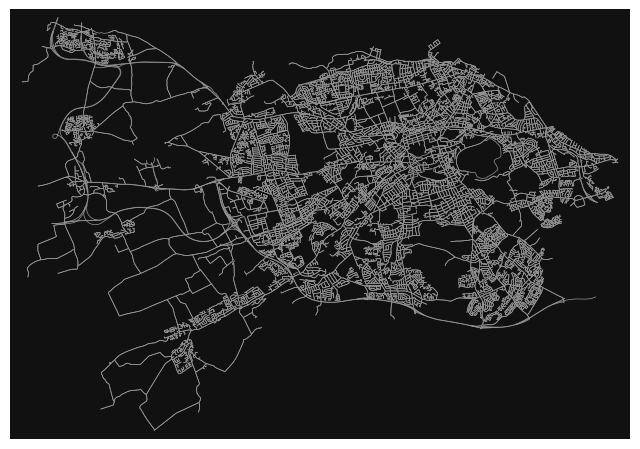

(<networkx.classes.multidigraph.MultiDiGraph at 0x19e2b563a30>,
                      y         x            highway  ref  street_count  \
 osmid                                                                    
 354026       55.925431 -3.415384  motorway_junction    2             3   
 354040       55.927636 -3.386314  motorway_junction    2             3   
 354097       55.921050 -3.319861                NaN  NaN             3   
 354100       55.924776 -3.310741                NaN  NaN             3   
 354815       55.943993 -3.405349                NaN  NaN             3   
 ...                ...       ...                ...  ...           ...   
 12438816803  55.932122 -3.129823                NaN  NaN             3   
 12469097114  55.931793 -3.203679                NaN  NaN             3   
 12480633444  55.947576 -3.178898     turning_circle  NaN             1   
 12500597978  55.930531 -3.124800                NaN  NaN             1   
 12512972718  55.928185 -3.127720   

In [10]:
def get_city_roads(city_name, network_type='drive'):
    ox.settings.use_cache = True
    ox.settings.log_console = True

    try:
        G = ox.graph_from_place(city_name, network_type=network_type)

        nodes, edges = ox.graph_to_gdfs(G)
        print(f"Number of nodes: {len(nodes)}")
        print(f"Number of edges: {len(edges)}")

        fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)
        plt.show()

        return G, nodes, edges

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return None, None, None


get_city_roads("edinburgh")

Number of nodes: 201
Number of edges: 566


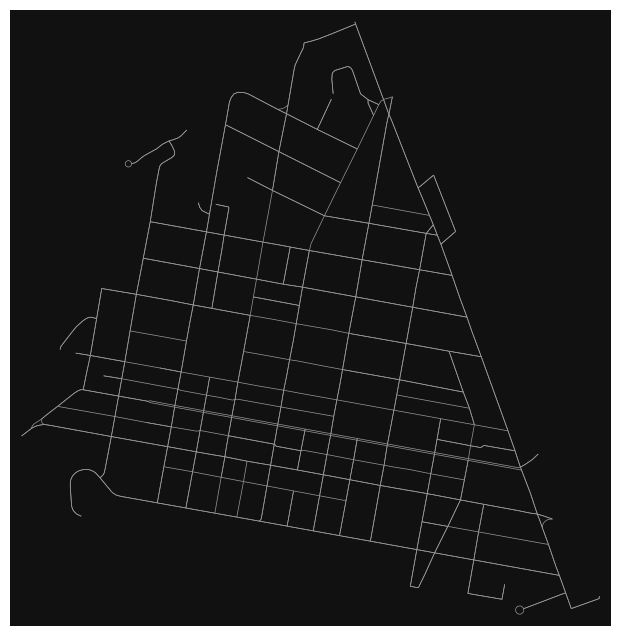


=== Road Attributes Analysis ===
Available attributes: ['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'geometry', 'maxspeed', 'lanes', 'tunnel', 'bridge', 'ref']

HIGHWAY Distribution:
residential      419
primary           80
tertiary          60
living_street      5
primary_link       1
Name: highway, dtype: int64

LANES Distribution:
2         11
3          8
5          2
[2, 3]     2
Name: lanes, dtype: int64

=== Specific Queries ===

Longest road segment: 271.49 meters
Road name: North Monroe Street

Total length by road type (meters):
highway
living_street      444.557765
primary           6886.105814
primary_link        45.016237
residential      40108.922769
tertiary          4813.268110
tertiary_link       27.184864
Name: length, dtype: float64


In [11]:
def analyze_road_attributes(edges):
    """Analyze specific road attributes"""

    print("\n=== Road Attributes Analysis ===")

    # Available attributes
    print("Available attributes:", edges.columns.tolist())

    # Analyze specific attributes if they exist
    attributes_to_check = ['highway', 'lanes']

    for attr in attributes_to_check:
        if attr in edges.columns:
            print(f"\n{attr.upper()} Distribution:")
            print(edges[attr].value_counts().head())


# Usage example
city = "Media, Pennsylvania, USA"
G, nodes, edges = get_city_roads(city)

if G is not None:
    analyze_road_attributes(edges)

    # Additional specific queries
    print("\n=== Specific Queries ===")

    # Find longest road segment
    if 'length' in edges.columns:
        longest_road = edges.sort_values('length', ascending=False).iloc[0]
        print(f"\nLongest road segment: {longest_road['length']:.2f} meters")
        if 'name' in edges.columns and longest_road['name']:
            print(f"Road name: {longest_road['name']}")

    # Calculate total network length by road type
    if 'highway' in edges.columns and 'length' in edges.columns:
        length_by_type = edges.groupby('highway')['length'].sum()
        print("\nTotal length by road type (meters):")
        print(length_by_type)


### Implementing and Using Dijkstra's Algorithm for Shortest Path Calculation

 **Dijkstra's Algorithm** to find the shortest path between two nodes in a road network graph. We use this for computing the most efficient routes in a city based on the street network data obtained from OpenStreetMap using **OSMnx**.

#### **Usage & Workflow**
1. **Convert OSMnx Graph to NetworkX**:  
   - The road network is first extracted using `get_city_roads(city_name)`, which returns a graph `G`.
   - A new `graph_for_dijkstra` is constructed as a **NetworkX Graph**, where edges contain a `length` attribute representing road distances.

2. **Run Dijkstra’s Algorithm**:  
   - The algorithm initializes all distances as `infinity` except for the start node.
   - It iteratively updates the shortest known distances to neighboring nodes.
   - Once the end node is reached (or all reachable nodes are visited), the shortest path is reconstructed.

3. **Retrieve Results**:  
   - If a valid path exists, the algorithm returns the shortest route and the total distance.
   - If no path exists, it returns `None` and `infinity`.

#### **Example Execution**
```python
city = "Media, Pennsylvania, USA"
G, nodes, edges = get_city_roads(city)

graph_for_dijkstra = nx.Graph()
for u, v, data in G.edges(data=True):
    graph_for_dijkstra.add_edge(u, v, length=data.get("length", 1))  # Default weight to 1 if missing

start_node_id = list(G.nodes)[0]  # Replace with a specific node ID
end_node_id = list(G.nodes)[-1]    # Replace with a specific node ID

shortest_path, shortest_distance = dijkstra(graph_for_dijkstra, start_node_id, end_node_id)

if shortest_path:
    print("Shortest path:", shortest_path)
    print("Shortest distance:", shortest_distance)
else:
    print(f"No path found between node {start_node_id} and {end_node_id}")
```

#### **Limitations & Potential Improvements**
- **Unweighted Default Edges**: If an edge lacks a `length` attribute, it is assigned a default weight of `1`, which may distort real-world distances.
- **Graph Representation**: The current implementation uses an **undirected graph** (`nx.Graph()`), which may not be ideal for roads with one-way streets. Using `nx.DiGraph()` (directed graph) would improve accuracy.
- **Performance on Large Graphs**: Dijkstra’s Algorithm runs in **O(V²)** time with an unoptimized approach (without priority queues). For large road networks, using **priority queues (heap-based approach)** via `heapq` or `networkx.shortest_path_length()` would improve efficiency.
- **Edge Data Handling**: The algorithm assumes that the edge data dictionary contains a `length` field, but in real datasets, additional preprocessing might be required to ensure consistency.

This implementation is a **basic** way to analyze shortest routes in a city's street network. Next steps would be to enhance it with **priority queues, proper directed graphs, and additional attributes (e.g., speed limits, traffic conditions)** to make it more usable.
```


In [12]:
def dijkstra(graph, start_node, end_node):
    
    distances = {node: float('inf') for node in graph.nodes}
    predecessors = {}
    distances[start_node] = 0
    unvisited = set(graph.nodes)

    while unvisited:
        current_node = min(unvisited, key=lambda node: distances[node])
        if distances[current_node] == float('inf'):
            break  # No path to remaining unvisited nodes

        if current_node == end_node:
            break  # Reached the destination node

        unvisited.remove(current_node)

        for neighbor, weight in graph[current_node].items():
            # Assuming edge data contains 'length' for weight.  Adapt if different.
            new_distance = distances[current_node] + weight.get('length', 1) # Default weight to 1 if 'length' is missing.
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current_node
    
    path = []
    current = end_node
    if end_node in predecessors:
      while current != start_node:
          path.insert(0, current)
          current = predecessors[current]
      path.insert(0, start_node)
      return path, distances[end_node]
    else:
      return None, float('inf')


In [25]:
start_node_id = list(G.nodes)[0]  # Replace with an actual node ID
end_node_id = list(G.nodes)[-4]  # Replace with an actual node ID

shortest_path, shortest_distance = dijkstra(G, start_node_id, end_node_id)


if shortest_path:
    print("Shortest path:", shortest_path)
    print("Shortest distance:", shortest_distance)
else:
    print(f"No path found between node {start_node_id} and {end_node_id}")

Shortest path: [109756437, 109756448, 2879166132, 109846243, 110006302, 109984404, 110174840, 110171507, 109793772, 110171518, 110039679, 110059519, 7191511871, 3382315755, 7191519530]
Shortest distance: 14


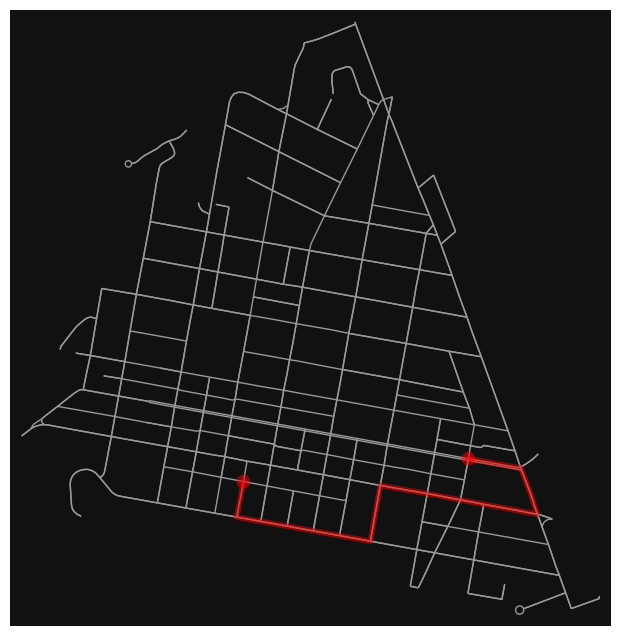

In [26]:
ox.plot_graph_route(G, shortest_path, route_color='r', route_linewidth=4, node_size=0)
plt.show()



In [15]:
import math 

def get_absolute_dist(a, b):
    return math.sqrt((a["x"] - b["x"])**2 + (a["y"] - b["y"])**2) 

In [ ]:
import heapq

def get_ac_dist(G, last, end):
    edge = G.get_edge_data(last, end)
    return edge[0]['length']

def A_star(G, start, end):
    start_node = G.nodes[start]
    end_node = G.nodes[end]
    open = []
    came_from = {}
    heapq.heappush(open, (0, {'node': start_node, 'nid': start, 'dist': 0}))
    # open = {{node: start, g: 0}}
    closed = {}

    while open:
        current = heapq.heappop(open)[1]
        node = current["node"]
        nid = current["nid"]
        # Deconstruct path information
        if nid == end: 
            path = []
            while nid in came_from:
                nid = came_from[nid];
                path.insert(0, nid)
            return path
        
        closed[nid] = current['dist']

        for neighbor in G.neighbors(nid):
            g = current['dist'] + get_ac_dist(G, nid, neighbor)
            
            if neighbor in closed and closed[neighbor] <= g:
                continue
            
            came_from[neighbor] = nid
            f = g + get_absolute_dist(G.nodes[neighbor], end_node)
            heapq.heappush(open, (f, {'node': G.nodes[neighbor], 'nid': neighbor, 'dist': g}))
            closed[neighbor] = True
            # print(neighbor)
        
        # closed[best_node] = True


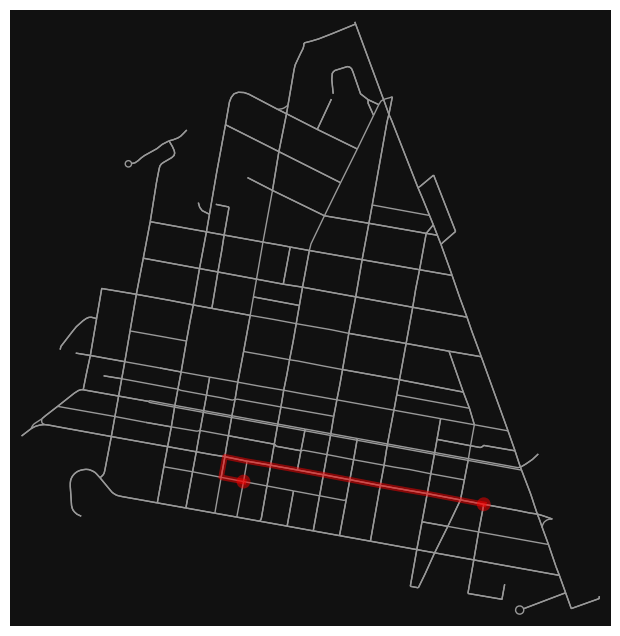

In [27]:
path_a_star = A_star(G, shortest_path[0], shortest_path[-4])
ox.plot_graph_route(G, path_a_star, route_color='r', route_linewidth=4, node_size=0)
plt.show()
